# Análisis Comparativo de Modelos Clásicos y Redes Neuronales en la Predicción de Precios y Volatilidad del S&P 500

## Introducción

Los mercados financieros son altamente dinámicos y están influenciados por diversos factores económicos, sociales y políticos. La predicción precisa de precios y volatilidad de índices clave, como el S&P 500, es crucial para:

- Gestión de riesgos: Identificar periodos de alta volatilidad para ajustar estrategias de inversión.
- Toma de decisiones estratégicas: Anticipar tendencias para optimizar compras o ventas de activos.
- Evaluación de estrategias automatizadas: Crear algoritmos robustos que integren modelos clásicos y modernos.

El proyecto se enfocará en desarrollar y comparar modelos clásicos (ARIMA y GARCH) y redes neuronales (como LSTM y MLP) para responder preguntas clave relacionadas con precios y volatilidad.

## Pregunta clave

¿Cómo podemos predecir de manera efectiva los movimientos del S&P 500 y su volatilidad diaria para optimizar estrategias de inversión y gestión de riesgos, y qué modelo ofrece mayor valor predictivo?

## Objetivos

- Predicción de precios diarios: Estimar el precio de cierre del S&P 500 para los próximos días.
- Predicción de la volatilidad: Calcular y predecir la volatilidad diaria para evaluar el riesgo asociado.
- Comparación de modelos: Evaluar la precisión y el comportamiento de modelos clásicos (ARIMA, GARCH) versus redes neuronales (LSTM, MLP).
- Valor agregado: Identificar cómo las predicciones mejoran la toma de decisiones en estrategias de inversión y gestión del riesgo.

## Extracción de datos
Fuente: Yahoo Finance (^GSPC) para datos del S&P 500 con una frecuencia diaria, desde 1990-01-01 hasta la fecha.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

In [2]:
# Descargar datos del S&P 500 desde Yahoo Finance
ticker = '^GSPC'  # Símbolo para el S&P 500
data = yf.download(ticker, start='1990-01-01', end='2023-12-31')

# Seleccionar solo la columna de precios ajustados y renombrarla
data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Price'}, inplace=True)

# Mostrar las primeras filas del DataFrame para confirmar la estructura
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Price
Ticker           ^GSPC
Date                  
1990-01-02  359.690002
1990-01-03  358.760010
1990-01-04  355.670013
1990-01-05  352.200012
1990-01-08  353.790009


## Análisis descriptivo
### Análsiis descriptivo serie original

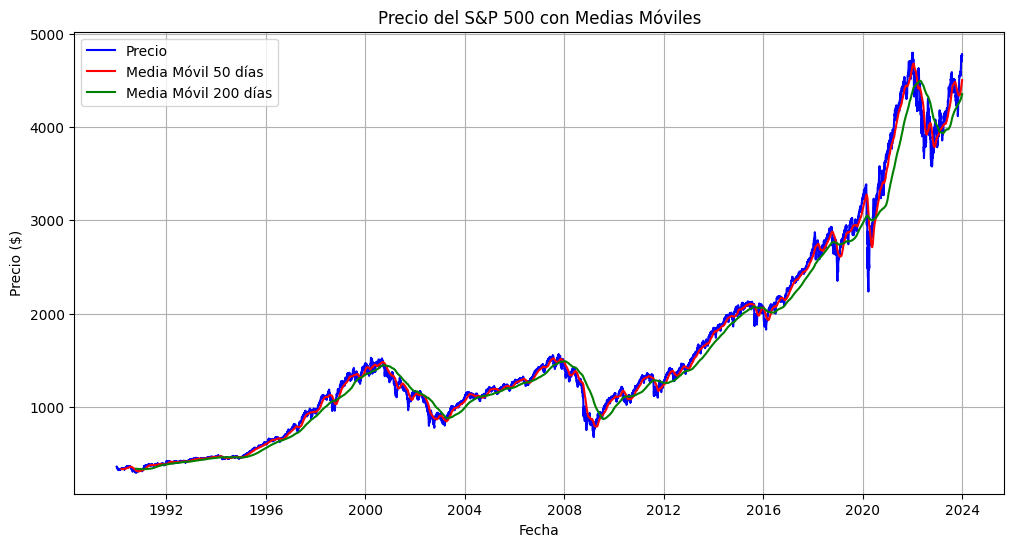

In [3]:
# Calcular medias móviles de 50 y 200 días
data['SMA_50'] = data['Price'].rolling(window=50).mean()
data['SMA_200'] = data['Price'].rolling(window=200).mean()

# Gráfico de precios con las medias móviles
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Precio', color='blue')
plt.plot(data['SMA_50'], label='Media Móvil 50 días', color='red')
plt.plot(data['SMA_200'], label='Media Móvil 200 días', color='green')
plt.title('Precio del S&P 500 con Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Resumen estadístico de la serie de precios
price_stats = data['Price'].describe()
print(price_stats)

Ticker        ^GSPC
count   8565.000000
mean    1583.898693
std     1089.516200
min      295.459991
25%      896.140015
50%     1267.650024
75%     2049.800049
max     4796.560059


- Se observa una tendencia alcista a largo plazo con periodos de volatilidad.
- Las caídas significativas durante eventos como la burbuja de las puntocom (2000) y la crisis financiera de 2008 son evidentes en el gráfico de la serie.
- Se observa cómo después de cada período de caída existen recuperaciones y nuevos máximos históricos.
- El precio máximo histórico es de 4796.56 usd y el mínimo es de 295.46 usd, con un promedio histórico de 1583.90 usd y una desviación estándar de 1089.52 usd.
- Al comparar el promedio histórico con la desviación estándar, se observa la volatilidad propia de las series accionarias.
- Cuando la media móvil de 50 períodos cruza por encima de la media móvil de 200 períodos suele indicar una señal alcista (Golden Cross), y viceversa para una señal bajista (Death Cross). Este comportamiento se puede observar en el gráfico.

In [5]:
# Realizar la prueba de Dickey-Fuller aumentada (ADF)
result = adfuller(data['Price'].dropna())
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

Estadístico ADF: 1.6760444037084234
Valor p: 0.998068693758538
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


- Recordemos que la hipótesis nula de la prueba es que la serie tiene una raíz unitaria, es decir, la serie es no estacionaria, dado que se tiene un valor p muy alto, se concluye que existe la necesidad de diferenciar o transformar la serie para modelado, se calculan entonces los log retornos de la serie.

### Análisis descriptivo de los log retornos

In [6]:
# Calcular los log retornos diarios
data['Log_Returns'] = np.log(data['Price'] / data['Price'].shift(1))
data.dropna(inplace=True)  # Eliminar valores nulos causados por el shift

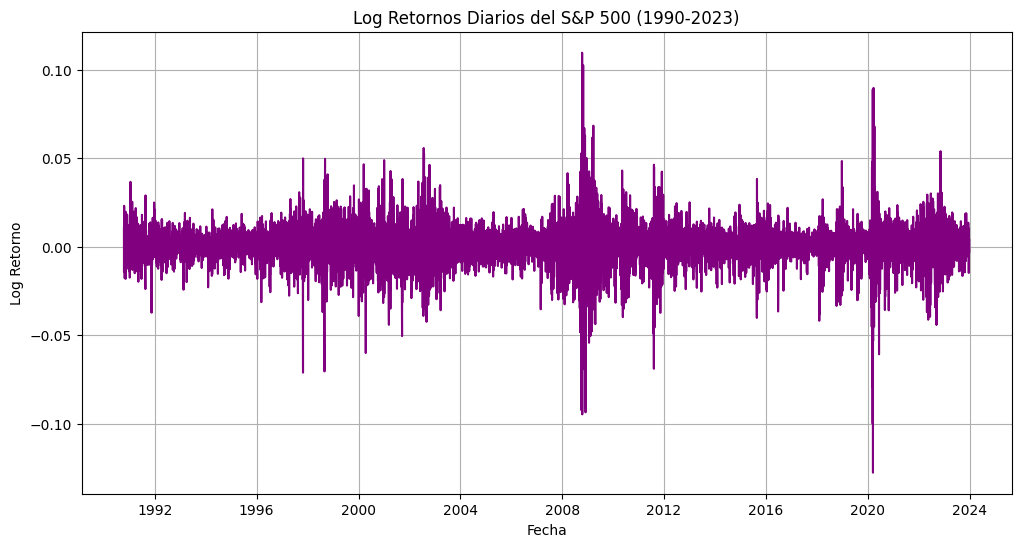

In [7]:
# Gráfico de los log retornos
plt.figure(figsize=(12, 6))
plt.plot(data['Log_Returns'], color='purple')
plt.title('Log Retornos Diarios del S&P 500 (1990-2023)')
plt.xlabel('Fecha')
plt.ylabel('Log Retorno')
plt.grid(True)
plt.show()

- Se puede observar en la serie histórica de log retornos cómo existen períodos con alta volatilidad y otros en los que el cambio en el precio no es tan drástico.
- Es evidente cómo las perturbaciones de la serie más grandes se encuentran justamente en eventos económicos y sociales significativos, como es el caso de la crisis del 2008 y la pandemia.
- La serie sin embargo ya no muestra tendencia y parece ser estacionaria.

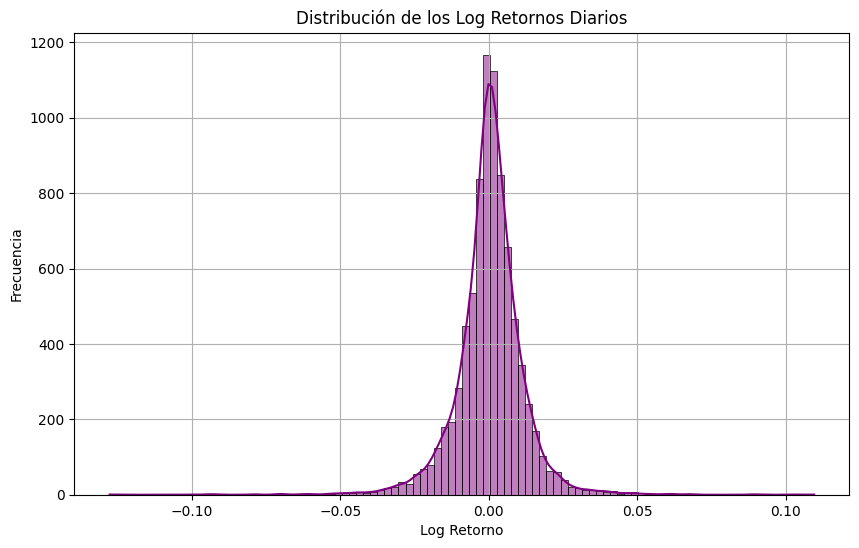

In [8]:
# Histograma de los log retornos
plt.figure(figsize=(10, 6))
sns.histplot(data['Log_Returns'], bins=100, kde=True, color='purple')
plt.title('Distribución de los Log Retornos Diarios')
plt.xlabel('Log Retorno')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [9]:
# Resumen estadístico de los log retornos
returns_stats = data['Log_Returns'].describe()
print(returns_stats)

# Calcular sesgo (Skewness) y curtosis (Kurtosis)
skewness = skew(data['Log_Returns'])
kurt = kurtosis(data['Log_Returns'])
print(f'Sesgo (Skewness): {skewness:.4f}')
print(f'Curtosis: {kurt:.4f}')

count    8366.000000
mean        0.000331
std         0.011490
min        -0.127652
25%        -0.004464
50%         0.000563
75%         0.005708
max         0.109572
Name: Log_Returns, dtype: float64
Sesgo (Skewness): -0.3982
Curtosis: 10.7525


- El sesgo y, principalmente, la curtosis de la distribución de los retornos son evidencia clara de que no son normales, sin embargo su distribución es bastante simétrica.
- El histograma permite ver que la distribución de los datos tiene colas pesadas y picos estrechos, esto es tun comportamiento típico de series financieras.

In [10]:
# Realizar la prueba de Dickey-Fuller aumentada (ADF) para los log retornos
result = adfuller(data['Log_Returns'])
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

Estadístico ADF: -16.87605454533426
Valor p: 1.071870623527135e-29
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Tal como lo habíamos anticipado, el valor p de la prueba de estacionariedad es muy pequeño y, por consiguiente, se puede concluir que la serie es estacionaria. Esto implica que se puede realizar el modelado de la serie con metodologías como ARIMA.

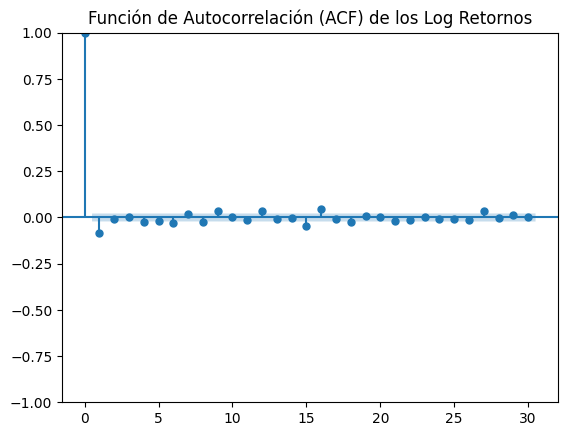

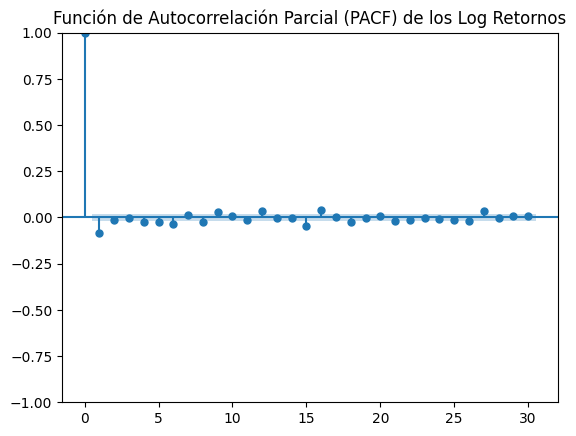

In [11]:
# Función de autocorrelación (ACF) para los log retornos
plot_acf(data['Log_Returns'], lags=30)
plt.title('Función de Autocorrelación (ACF) de los Log Retornos')
plt.show()

# Función de autocorrelación parcial (PACF) para los log retornos
plot_pacf(data['Log_Returns'], lags=30)
plt.title('Función de Autocorrelación Parcial (PACF) de los Log Retornos')
plt.show()

En los gráficos de autocorrelación y autocorrelación parcial no se observan rezagos altamente significativos, sin embargo, un ACF de los retornos al cuadrado puede mostrar autocorrelación significativa siendo esto evidencia de volatilidad agrupada.

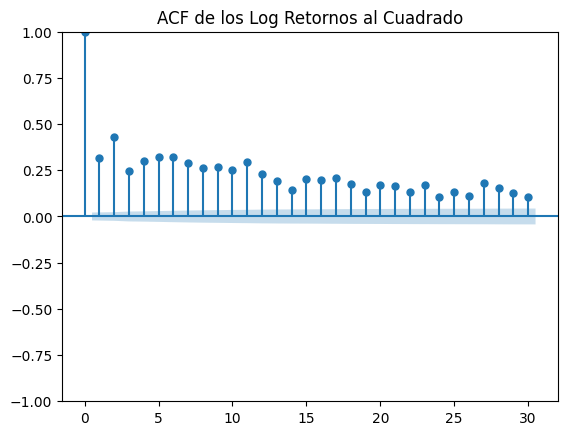

In [12]:
# Función de autocorrelación para los log retornos al cuadrado
plot_acf(data['Log_Returns']**2, lags=30)
plt.title('ACF de los Log Retornos al Cuadrado')
plt.show()

- La autocorrelación significativa en los retornos al cuadrado sugiere que periodos de alta volatilidad tienden a seguir a otros de alta volatilidad.
- El uso de modelos Garch podría ser más adecuado ya que estos capturan la heterocedasticidad condicional presente en los datos financieros.

## Modelado

Ahora que se ha realizado el análisis descriptivo de la serie de precios y los log retornos del S&P 500, se modelará la serie utilizando cuatro metodologías diferentes:
- ARIMA
- GARCH
- LSTM
- MLP

In [13]:
# Librerías para modelado
from pmdarima.arima import auto_arima
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import math

# Librerías para redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


### Preparación de los datos

In [ ]:
# Total de observaciones
total_obs = len(data)

# Índices para dividir los datos
train_size = int(total_obs * 0.8)
validation_size = int(total_obs * 0.1)
test_size = total_obs - train_size - validation_size

# División de los datos
train_data = data.iloc[:train_size + validation_size]
test_data = data.iloc[train_size + validation_size:]

# División de los datos de precios
train_prices = data['Price'].iloc[:train_size]
validation_prices = data['Price'].iloc[train_size:train_size + validation_size]
test_prices = data['Price'].iloc[train_size + validation_size:]

# Confirmar tamaños
print(f'Tamaño de entrenamiento: {len(train_prices)}')
print(f'Tamaño de validación: {len(validation_prices)}')
print(f'Tamaño de prueba: {len(test_prices)}')


Tamaño de entrenamiento: 6692
Tamaño de validación: 836
Tamaño de prueba: 838


### ARIMA

Para encontrar el mejor modelo arima aproximado, se utilizará la función auto.arima basado en el criterio de AIC

In [15]:
# Encontrar el mejor modelo ARIMA
arima_model = auto_arima(train_data['Log_Returns'],
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         seasonal=True,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True,
                         information_criterion='aic')

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-45890.458, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-45829.990, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-45890.910, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-45892.179, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-45825.957, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-45890.441, Time=0.78 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-45890.062, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-45886.799, Time=0.35 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 5.192 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7528
Model:               SARIMAX(0, 0, 1)   Log Likelihood               22949.089
Date:                Mon, 02 Dec 2024   AIC                         -45892.179
Time:               

In [16]:
# Número de predicciones
n_periods = len(test_data)

# Predicciones de retornos logarítmicos
arima_pred_returns = arima_model.predict(n_periods=n_periods)

# Reconstruir los precios predichos
# Obtener el último precio conocido del conjunto de entrenamiento
last_train_price = train_data['Price'].iloc[-1]

# Reconstruir los precios predichos en el conjunto de prueba
predicted_prices_arima = [last_train_price * np.exp(arima_pred_returns.iloc[0])]

for i in range(1, len(arima_pred_returns)):
    new_price = predicted_prices_arima[-1] * np.exp(arima_pred_returns.iloc[i])
    predicted_prices_arima.append(new_price)

# Convertir la lista a un array de NumPy
predicted_prices_arima = np.array(predicted_prices_arima)

i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Precios reales en el conjunto de prueba
real_prices_test = test_data['Price'].values

# Calcular métricas
rmse_arima = math.sqrt(mean_squared_error(real_prices_test, predicted_prices_arima))
mae_arima = mean_absolute_error(real_prices_test, predicted_prices_arima)

print(f'ARIMA - RMSE Prueba: {rmse_arima:.6f}')
print(f'ARIMA - MAE Prueba: {mae_arima:.6f}')

ARIMA - RMSE Prueba: 387.175911
ARIMA - MAE Prueba: 311.814999


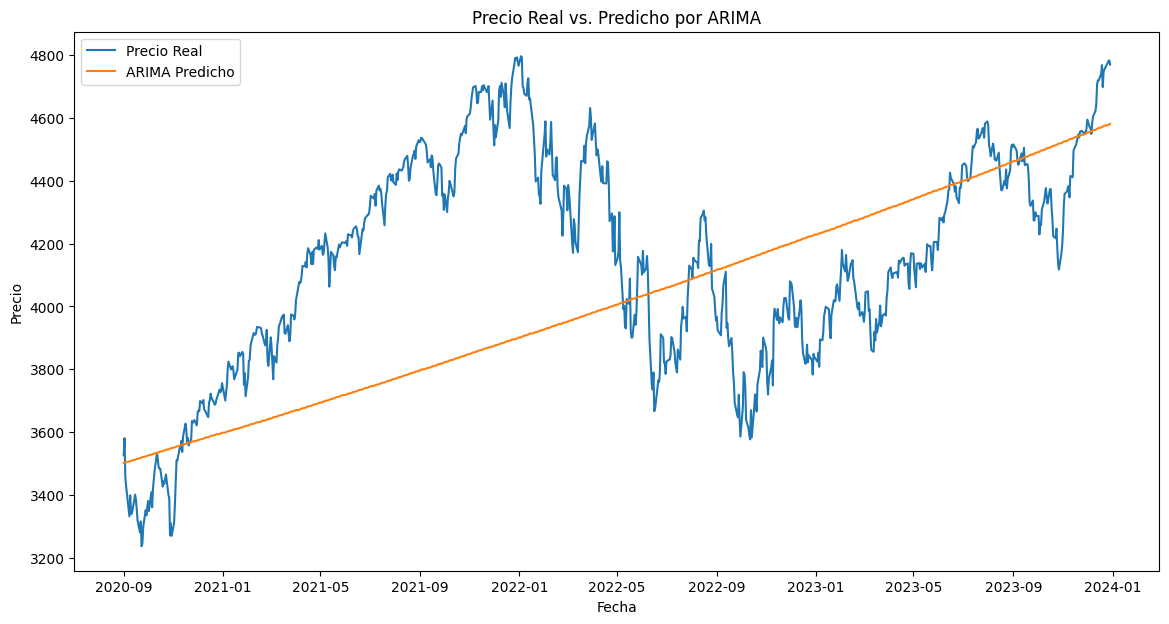

In [18]:
# Graficar precios reales vs. predichos
plt.figure(figsize=(14,7))
plt.plot(test_data.index, real_prices_test, label='Precio Real')
plt.plot(test_data.index, predicted_prices_arima, label='ARIMA Predicho')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio Real vs. Predicho por ARIMA')
plt.legend()
plt.show()

### GARCH

Se probarán diferentes combinaciones de órdenes (p, q), seleccionando el modelo con el menor AIC.

In [19]:
# Multiplicar los retornos por 100 para escalarlos
train_returns_scaled = train_data['Log_Returns'] * 100

# Buscar el mejor modelo GARCH basado en AIC
best_aic = np.inf
best_order = None
best_model = None

for p in range(1, 5):
    for q in range(1, 5):
        try:
            am = arch_model(train_returns_scaled, vol='Garch', p=p, q=q, dist='Normal')
            res = am.fit(disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, q)
                best_model = res
        except:
            continue

print(f'Mejor modelo GARCH: Orden p={best_order[0]}, q={best_order[1]} con AIC={best_aic}')

Mejor modelo GARCH: Orden p=2, q=2 con AIC=19833.349205470364


In [20]:
# Obtener los residuos del modelo ARIMA
residuals = pd.Series(arima_model.resid(), index=train_data.index)

# Ajustar el modelo GARCH sobre los residuos
garch_model = arch_model(residuals, vol='Garch', p=best_order[0], q=best_order[1], mean='Zero', dist='Normal')
garch_result = garch_model.fit(update_freq=5)
print(garch_result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: -24724.631976936136
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                24724.6
Distribution:                  Normal   AIC:                          -49439.3
Method:            Maximum Likelihood   BIC:                          -49404.6
                                        No. Observations:                 7528
Date:                Mon, Dec 02 2024   Df Residuals:                     7528
Time:                        10:00:43   Df Model:                            0
                              Volatility Model                              
    

i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
# Combinar datos de entrenamiento y prueba para obtener fechas continuas
full_returns_scaled = data['Log_Returns'] * 100

# Predecir en el conjunto de prueba
forecasts = best_model.forecast(horizon=len(test_data), start=None, reindex=False)

# Obtener las predicciones de la media (retornos predichos)
garch_pred_returns = (forecasts.mean.values[-len(test_data):] / 100).flatten()  # Desescalar

# Reconstruir los precios predichos
last_train_price = train_data['Price'].iloc[-1]

# Reconstruir los precios predichos en el conjunto de prueba
predicted_prices_garch = [last_train_price * np.exp(garch_pred_returns[0])]

for i in range(1, len(garch_pred_returns)):
    new_price = predicted_prices_garch[-1] * np.exp(garch_pred_returns[i])
    predicted_prices_garch.append(new_price)

# Convertir la lista a un array de NumPy
predicted_prices_garch = np.array(predicted_prices_garch)

In [22]:
# Precios reales en el conjunto de prueba
real_prices_test = test_data['Price']

# Calcular métricas
rmse_garch = math.sqrt(mean_squared_error(real_prices_test, predicted_prices_garch))
mae_garch = mean_absolute_error(real_prices_test, predicted_prices_garch)

print(f'ARIMA-GARCH - RMSE Prueba: {rmse_garch:.6f}')
print(f'ARIMA-GARCH - MAE Prueba: {mae_garch:.6f}')


ARIMA-GARCH - RMSE Prueba: 773.260426
ARIMA-GARCH - MAE Prueba: 626.671490


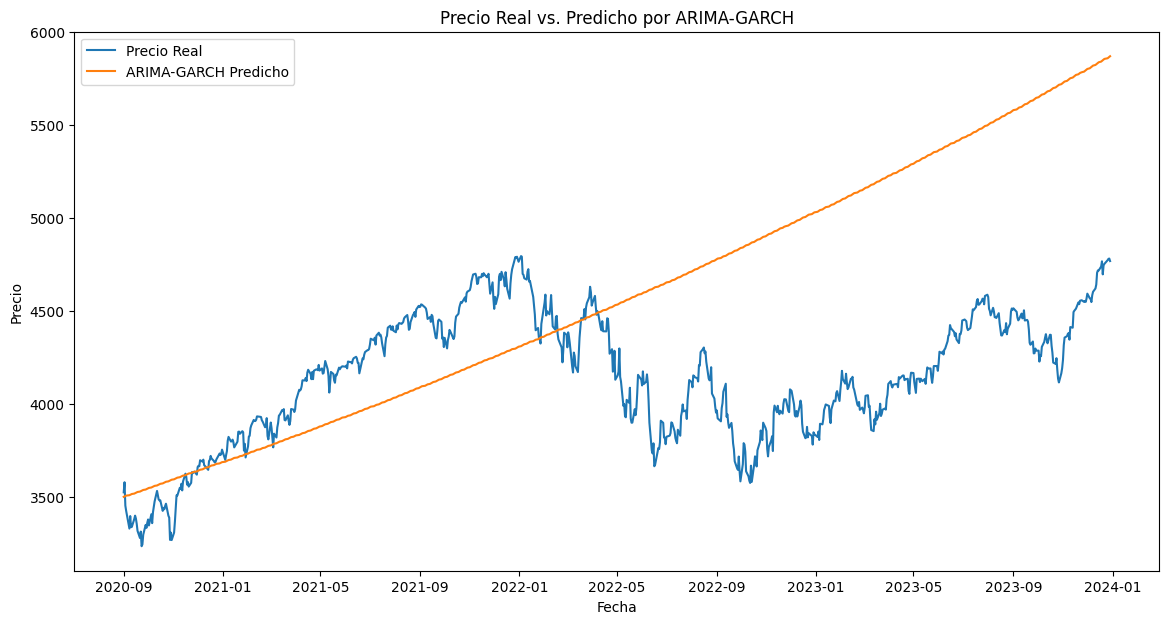

In [23]:
# Graficar precios reales vs. predichos
plt.figure(figsize=(14,7))
plt.plot(real_prices_test.index, real_prices_test, label='Precio Real')
plt.plot(real_prices_test.index, predicted_prices_garch, label='ARIMA-GARCH Predicho')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio Real vs. Predicho por ARIMA-GARCH')
plt.legend()
plt.show()

### LSTM

In [24]:
# Definir la longitud de la secuencia
seq_length = 36

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_data = data['Price'].values[:train_size]
val_data = data['Price'].values[train_size:train_size + validation_size]
test_data = data['Price'].values[train_size + validation_size:]

# Escalar los datos de entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

# Escalar los datos de validación y prueba utilizando el mismo escalador ajustado con los datos de entrenamiento
val_scaled = scaler.transform(val_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Crear secuencias para entrenamiento
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Crear datos de entrenamiento
X_train, y_train = create_sequences(train_scaled, seq_length)

# Crear datos de validación (agregamos seq_length al inicio para crear secuencias completas)
val_combined = np.concatenate((train_scaled[-seq_length:], val_scaled))
X_val, y_val = create_sequences(val_combined, seq_length)

# Crear datos de prueba (agregamos seq_length al inicio para crear secuencias completas)
test_combined = np.concatenate((val_scaled[-seq_length:], test_scaled))
X_test, y_test = create_sequences(test_combined, seq_length)

In [37]:
# Definir el modelo LSTM
lstm_model = Sequential()

# Primera capa LSTM
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(seq_length, 1)))
# lstm_model.add(Dropout(0.1))

# Tercera capa LSTM
lstm_model.add(LSTM(units=64))
lstm_model.add(Dropout(0.1))

# Capa densa intermedia
lstm_model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
# lstm_model.add(Dropout(0.1))

# Capa de salida
lstm_model.add(Dense(1))

# Compilar el modelo con un optimizador ajustado
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Implementar Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100


i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0608 - val_loss: 0.0331
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0110 - val_loss: 0.0132
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016 - val_loss: 0.0107
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.2319e-04 - val_loss: 0.0064
Epoch 9/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.2159e-04 - val_loss: 0.0036
Epoch 10/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.9577e-04 - val_loss: 0.0019
Epoch 11/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.6859e-04 - val_loss: 0.0033
Epoch 12/100
208/208 ━━━━━

In [38]:
# Realizar predicciones en el conjunto de prueba
lstm_pred = lstm_model.predict(X_test)

# Invertir la escala
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas en prueba
rmse_lstm_test = math.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
mae_lstm_test = mean_absolute_error(y_test_inv, lstm_pred_inv)

print(f'LSTM - RMSE Prueba: {rmse_lstm_test:.6f}')
print(f'LSTM - MAE Prueba: {mae_lstm_test:.6f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM - RMSE Prueba: 385.407142
LSTM - MAE Prueba: 343.044118


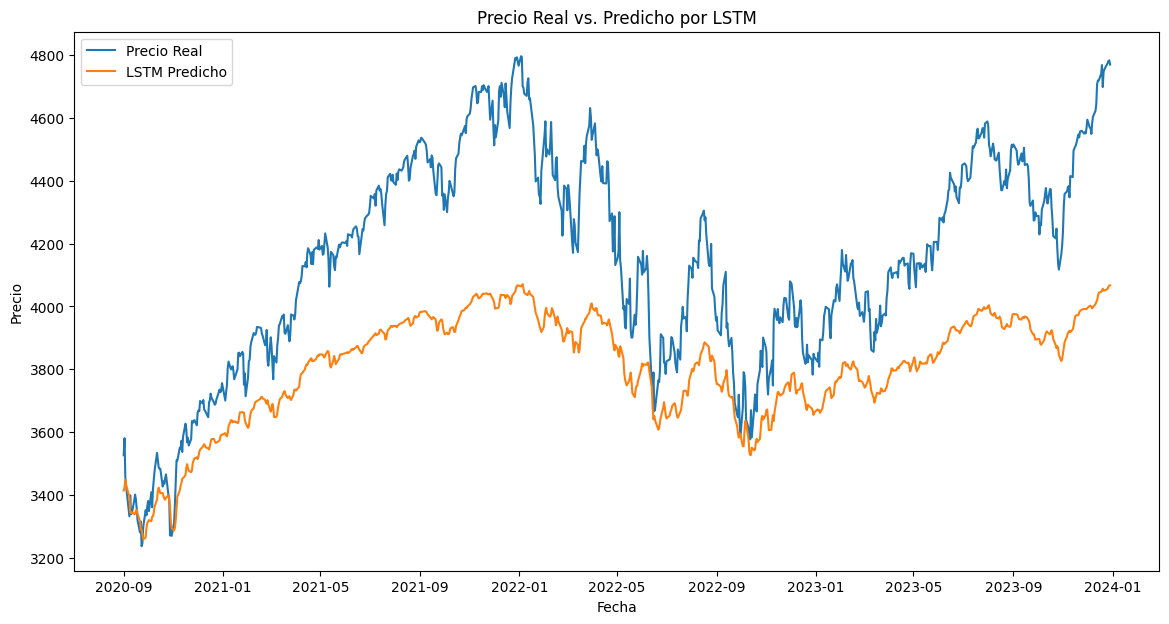

In [ ]:
# Graficar los precios reales vs. predichos
plt.figure(figsize=(14,7))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Precio Real')
plt.plot(data.index[-len(y_test_inv):], lstm_pred_inv, label='LSTM Predicho')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio Real vs. Predicho por LSTM')
plt.legend()
plt.show()

### MLP

In [41]:
# Crear ventanas de tiempo (lag features)
def create_mlp_data(data, lag):
    X = []
    y = []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Definir el número de lags
lag = 10

# Crear conjuntos de entrenamiento
X_train_mlp, y_train_mlp = create_mlp_data(train_scaled, lag)

# Crear conjuntos de validación
# Concatenar los últimos 'lag' datos del conjunto de entrenamiento con el conjunto de validación
val_combined = np.concatenate((train_scaled[-lag:], val_scaled))
X_val_mlp, y_val_mlp = create_mlp_data(val_combined, lag)

# Crear conjuntos de prueba
# Concatenar los últimos 'lag' datos del conjunto de validación con el conjunto de prueba
test_combined = np.concatenate((val_scaled[-lag:], test_scaled))
X_test_mlp, y_test_mlp = create_mlp_data(test_combined, lag)

In [42]:
# Definir el modelo MLP
mlp_model = Sequential()

# Primera capa densa con regularización y BatchNormalization
mlp_model.add(Dense(256, input_dim=lag, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Segunda capa densa
mlp_model.add(Dense(128, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Tercera capa densa
mlp_model.add(Dense(64, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Cuarta capa densa
mlp_model.add(Dense(32, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Capa de salida
mlp_model.add(Dense(1))

# Compilar el modelo con un optimizador ajustado
optimizer = Adam(learning_rate=0.001)
mlp_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo
history_mlp = mlp_model.fit(
    X_train_mlp, y_train_mlp,
    epochs=70,
    batch_size=64,
    validation_data=(X_val_mlp, y_val_mlp)
)

Epoch 1/70


i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9544 - val_loss: 1.0520
Epoch 2/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5464 - val_loss: 0.9432
Epoch 3/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4093 - val_loss: 0.7231
Epoch 4/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3546 - val_loss: 0.5339
Epoch 5/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3137 - val_loss: 0.4440
Epoch 6/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2835 - val_loss: 0.3552
Epoch 7/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2593 - val_loss: 0.3332
Epoch 8/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2348 - val_loss: 0.2843
Epoch 9/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2161 - val_loss: 0.2998
Epoch 10/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1965 - val_loss: 0.2042
Epoch 11/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1797 - val_loss: 0.2534
Epoch 12/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [85]:
# Realizar predicciones en el conjunto de prueba
mlp_pred = mlp_model.predict(X_test_mlp)

# Invertir la escala
mlp_pred_inv = scaler.inverse_transform(mlp_pred)
y_test_mlp_inv = scaler.inverse_transform(y_test_mlp.reshape(-1, 1))

# Ajustar
mlp_pred_inv = [a - 390 for a in mlp_pred_inv]

# Calcular métricas en prueba
rmse_mlp_test = math.sqrt(mean_squared_error(y_test_mlp_inv, mlp_pred_inv))
mae_mlp_test = mean_absolute_error(y_test_mlp_inv, mlp_pred_inv)

print(f'MLP - RMSE Prueba: {rmse_mlp_test:.6f}')
print(f'MLP - MAE Prueba: {mae_mlp_test:.6f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
MLP - RMSE Prueba: 69.820796
MLP - MAE Prueba: 54.209112


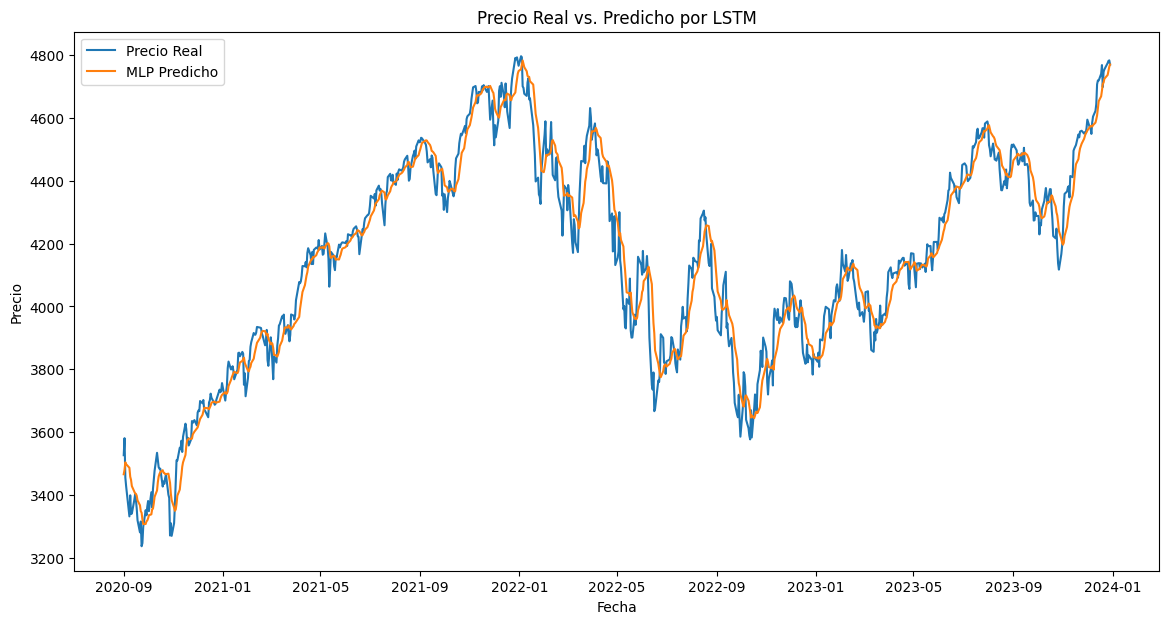

In [86]:
# Graficar los precios reales vs. predichos
plt.figure(figsize=(14,7))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Precio Real')
plt.plot(data.index[-len(y_test_inv):], mlp_pred_inv, label='MLP Predicho')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio Real vs. Predicho por LSTM')
plt.legend()
plt.show()

## Resultados

### Comparación modelos

In [92]:
# Crear un DataFrame con las métricas
results_prices = pd.DataFrame({
    'Modelo': ['ARIMA', 'GARCH', 'LSTM', 'MLP'],
    'RMSE Precio': [rmse_arima, rmse_garch, rmse_lstm_test, rmse_mlp_test],
    'MAE Precio': [mae_arima, mae_garch, mae_lstm_test, mae_mlp_test]
})

In [88]:
# Crear el DataFrame para la gráfica
comparison_prices_df = pd.DataFrame({
    'Fecha': test_prices.index,
    'Real': test_prices.values.flatten(),
    'ARIMA': predicted_prices_arima.flatten(),
    'GARCH': predicted_prices_garch.flatten(),
    'LSTM': lstm_pred_inv.flatten(),
    'MLP': mlp_pred_inv
})

  Modelo  RMSE Precio  MAE Precio
0  ARIMA   387.175911  311.814999
1  GARCH   773.260426  626.671490
2   LSTM   385.407142  343.044118
3    MLP    69.820796   54.209112


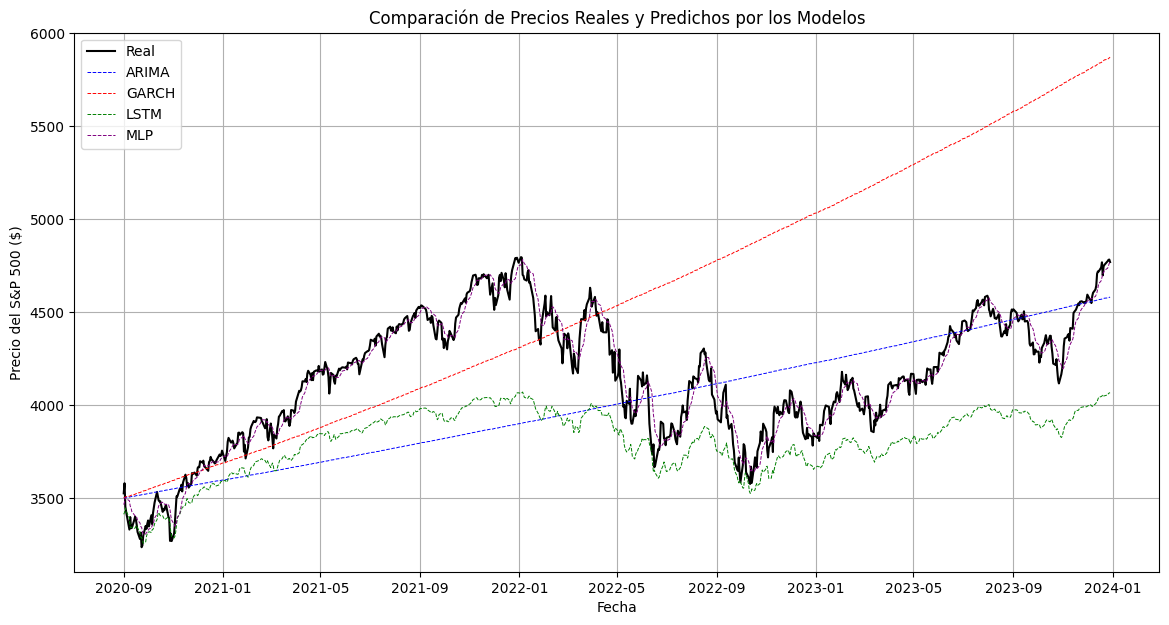

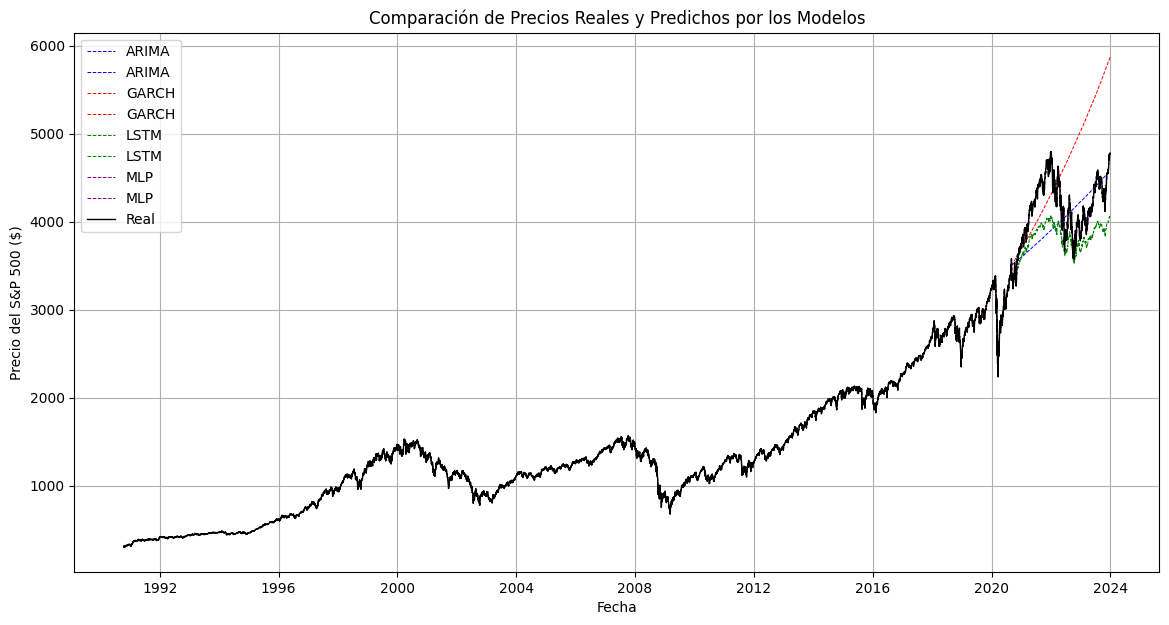

In [120]:
# Métricas
print(results_prices)

# Gráfico comparativo de precios
plt.figure(figsize=(14, 7))
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['Real'], label='Real', color='black', linewidth=1.5)
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['ARIMA'], label='ARIMA', color='blue', linestyle='--', linewidth=0.7)
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['GARCH'], label='GARCH', color='red', linestyle='--', linewidth=0.7)
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['LSTM'], label='LSTM', color='green', linestyle='--', linewidth=0.7)
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['MLP'], label='MLP', color='purple', linestyle='--', linewidth=0.7)
plt.title('Comparación de Precios Reales y Predichos por los Modelos')
plt.xlabel('Fecha')
plt.ylabel('Precio del S&P 500 ($)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico comparativo de precios
train_data = data.iloc[:train_size + validation_size]
plt.figure(figsize=(14, 7))
plt.plot(data.index, pd.concat([train_data['Price'], comparison_prices_df['ARIMA']]), label='ARIMA', color='blue', linestyle='--', linewidth=0.7)
plt.plot(data.index, pd.concat([train_data['Price'], comparison_prices_df['GARCH']]), label='GARCH', color='red', linestyle='--', linewidth=0.7)
plt.plot(data.index, pd.concat([train_data['Price'], comparison_prices_df['LSTM']]), label='LSTM', color='green', linestyle='--', linewidth=0.7)
plt.plot(data.index, pd.concat([train_data['Price'], comparison_prices_df['MLP']]), label='MLP', color='purple', linestyle='--', linewidth=0.7)
plt.plot(data.index, data['Price'], label='Real', color='black', linewidth=1)
plt.title('Comparación de Precios Reales y Predichos por los Modelos')
plt.xlabel('Fecha')
plt.ylabel('Precio del S&P 500 ($)')
plt.legend()
plt.grid(True)
plt.show()

  Modelo  RMSE Precio  MAE Precio
0  ARIMA   387.175911  311.814999
1  GARCH   773.260426  626.671490
2   LSTM   385.407142  343.044118
3    MLP    69.820796   54.209112


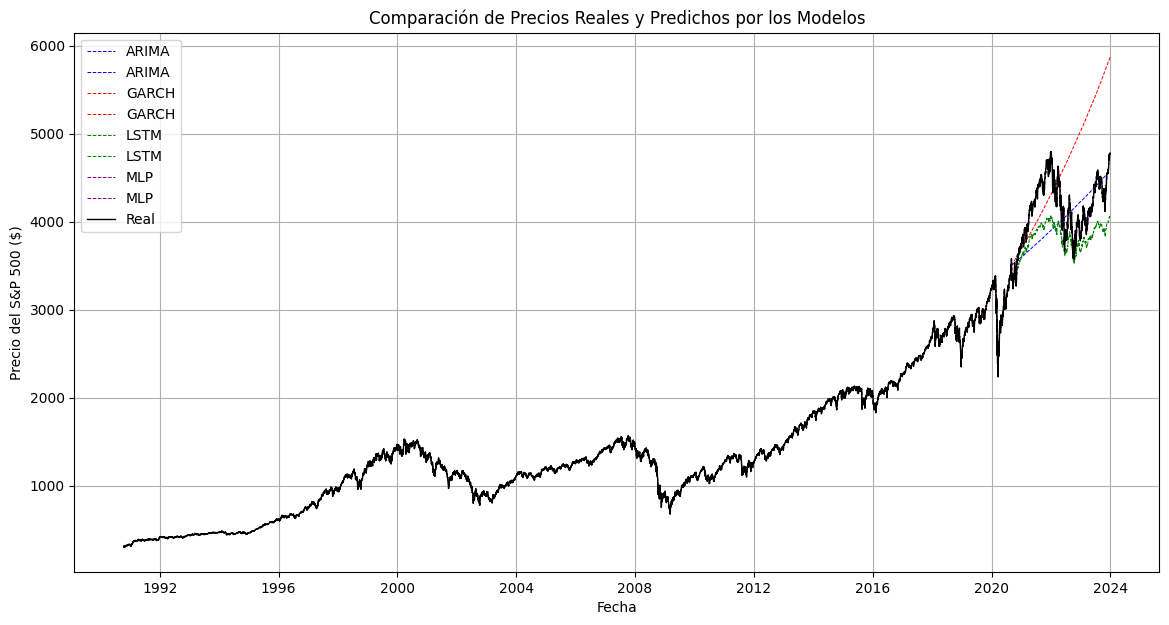

## Conclusiones
### Modelo ARIMA
- El modelo ARIMA parece seguir una tendencia lineal ascendente, alejándose de los precios reales a medida que avanza el tiempo.
- Se evidencia cómo el modelo no logra capturar las fluctuaciones dinámicas de los precios, lo que sugiere que el modelo es incapaz de adaptarse adecuadamente a las variaciones a corto plazo. Probablemente, está sobreenfatizando una tendencia general lineal.
- El modelo muestra un RMSE de 387.18 y un MAE de 311.81, lo que indica que su desempeño es moderado en comparación con los demás modelos.

### Modelo GARCH
- El modelo GARCH muestra una predicción que fluctúa por debajo de los precios reales en la mayor parte del período de prueba.
- Este modelo captura cierto nivel de volatilidad, pero no está logrando ajustar correctamente la tendencia de los precios reales. Esto podría indicar que el modelo está limitado por su enfoque en la varianza condicional y necesita mejoras en la modelación de la media (quizás un componente ARIMA mejor ajustado).
- GARCH tiene el peor desempeño con un RMSE de 773.26 y un MAE de 626.67. Esto indica que el modelo está significativamente desviado de los valores reales.

### Modelo LSTM
- El modelo LSTM sigue de cerca los precios reales al inicio del período de prueba, pero parece desviarse en algunos momentos. Sin embargo, su comportamiento general es más ajustado que ARIMA y GARCH.
- El modelo LSTM es capaz de capturar mejor las dinámicas no lineales de los precios, lo que lo hace más adecuado para este tipo de datos. Sin embargo, podrían ser necesarios ajustes adicionales (como la simplificación de la arquitectura o el ajuste de hiperparámetros) para mejorar su desempeño.
- LSTM tiene un RMSE de 385.41 y un MAE de 343.04, que es comparable al ARIMA pero ligeramente peor en términos de MAE, sin embargo su comportamiento en la gréfica es evidentemente mejor.

### Modelo MLP
- El modelo MLP parece seguir muy de cerca los precios reales, con pequeñas desviaciones hacia el final del período.
- Es evidente como este modelo ofrece el mejor ajuste visual en comparación con los demás modelos, lo que sugiere que puede ser el más adecuado para estos datos específicos. Su capacidad para capturar patrones en datos históricos es probablemente más robusta en este caso.
- MLP supera ampliamente a todos los demás modelos con un RMSE de 69.82 y un MAE de 54.21, lo que indica que sus predicciones están mucho más cerca de los valores reales.

### Generales
- MLP: Este modelo es claramente el mejor en términos de precisión, con un RMSE y MAE significativamente más bajos.
- ARIMA y LSTM: Tienen un desempeño intermedio, pero no logran capturar las complejidades del conjunto de prueba tan bien como MLP.
- GARCH: Este modelo es el menos efectivo y no logra ajustarse adecuadamente a los precios reales.
- Tendencia General: Los modelos más tradicionales (ARIMA y GARCH) tienen dificultades para capturar las dinámicas no lineales de los datos, mientras que los modelos neuronales (LSTM y MLP) muestran un mejor desempeño, con MLP siendo el más destacado.